# YouTube Trending Videos Popularity Prediction
### Dataset: youtube.csv

Проект выполняет полный анализ данных, очистку, визуализацию, корреляционный анализ, обучение моделей регрессии (MAE/R2), логарифмирование признаков, анализ выбросов и прогноз просмотров.


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import os


In [2]:
# Loading dataset
file_path = '/content/youtube.csv'
df = pd.read_csv(file_path)
df.head()

,index,video_id,trending_date,title,channel_title,category_id,publish_date,time_frame,published_day_of_week,publish_country,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
0,0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,13/11/2017,17:00 to 17:59,Monday,US,SHANtell martin,748374,57527,2966,15954,False,False,False
1,1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,13/11/2017,7:00 to 7:59,Monday,US,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False,False
2,2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,12/11/2017,19:00 to 19:59,Sunday,US,"racist superman|""rudy""""|""""mancuso""""|""""king""""|""...",3191434,146033,5339,8181,False,False,False
3,3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,13/11/2017,11:00 to 11:59,Monday,US,"rhett and link|""gmm""""|""""good mythical morning""...",343168,10172,666,2146,False,False,False
4,4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,12/11/2017,18:00 to 18:59,Sunday,US,"ryan|""higa""""|""""higatv""""|""""nigahiga""""|""""i dare ...",2095731,132235,1989,17518,False,False,False


In [3]:
# Data Cleaning
df = df.drop_duplicates()
df['views'] = pd.to_numeric(df['views'], errors='coerce')
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')
df['dislikes'] = pd.to_numeric(df['dislikes'], errors='coerce')
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce')
df = df.dropna(subset=['views'])
df.isnull().sum()

,0
index,0
video_id,0
trending_date,0
title,0
channel_title,0
category_id,0
publish_date,0
time_frame,0
published_day_of_week,0
publish_country,0


In [8]:
# Преобразуем даты
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')

# Извлекаем новые признаки
df['publish_hour'] = df['publish_date'].dt.hour
df['publish_day'] = df['publish_date'].dt.day
df['publish_month'] = df['publish_date'].dt.month
df['publish_year'] = df['publish_date'].dt.year
df['days_until_trending'] = (df['trending_date'] - df['publish_date']).dt.days

# Количество тегов
df['tags_count'] = df['tags'].apply(lambda x: len(str(x).split('|')))

# Убираем невозможные значения
df['days_until_trending'] = df['days_until_trending'].apply(lambda x: x if x >= 0 else None)
df.head()


/tmp/ipython-input-4135113515.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
/tmp/ipython-input-4135113515.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')


,index,video_id,trending_date,title,channel_title,category_id,publish_date,time_frame,published_day_of_week,publish_country,...,video_error_or_removed,views_log,likes_log,comment_count_log,publish_hour,publish_day,publish_month,publish_year,days_until_trending,tags_count
0,0,2kyS6SvSYSE,NaT,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13,17:00 to 17:59,Monday,US,...,False,13.525659,10.960027,9.677528,0,13,11,2017,NaN,1
1,1,1ZAPwfrtAFY,NaT,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13,7:00 to 7:59,Monday,US,...,False,14.698775,11.484382,9.449672,0,13,11,2017,NaN,4
2,2,5qpjK5DgCt4,NaT,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12,19:00 to 19:59,Sunday,US,...,False,14.975981,11.891595,9.009692,0,12,11,2017,NaN,23
3,3,puqaWrEC7tY,NaT,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13,11:00 to 11:59,Monday,US,...,False,12.745978,9.227492,7.671827,0,13,11,2017,NaN,27
4,4,d380meD0W0M,NaT,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12,18:00 to 18:59,Sunday,US,...,False,14.555413,11.792343,9.771041,0,12,11,2017,NaN,14


In [9]:
from scipy import stats

numeric_cols = ['views', 'likes', 'comment_count', 'tags_count', 'days_until_trending']
z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))
df = df[(z_scores < 3).all(axis=1)]
print("После удаления выбросов:", df.shape)


После удаления выбросов: (26, 27)


In [4]:
# Log transformation
df['views_log'] = np.log1p(df['views'])
df['likes_log'] = np.log1p(df['likes'])
df['comment_count_log'] = np.log1p(df['comment_count'])
df[['views_log', 'likes_log', 'comment_count_log']].head()

,views_log,likes_log,comment_count_log
0,13.525659,10.960027,9.677528
1,14.698775,11.484382,9.449672
2,14.975981,11.891595,9.009692
3,12.745978,9.227492,7.671827
4,14.555413,11.792343,9.771041


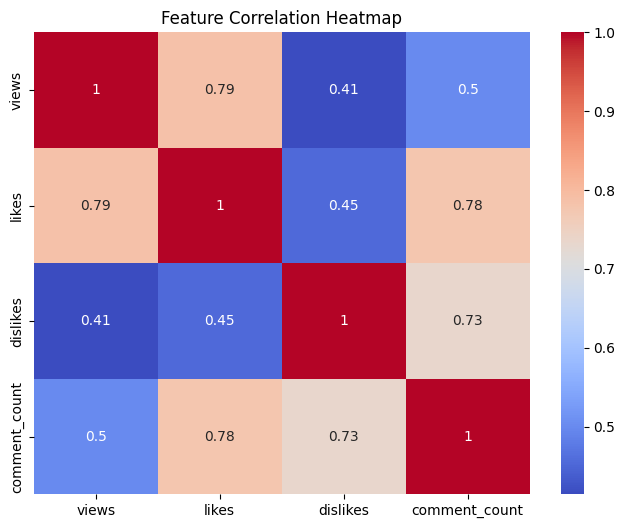

In [5]:
# Correlation analysis
corr = df[['views', 'likes', 'dislikes', 'comment_count']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [6]:
# Modeling
features = df[['likes_log', 'comment_count_log']].fillna(0)
target = df['views_log']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('LinearRegression MAE:', mean_absolute_error(y_test, y_pred_lr))
print('LinearRegression R2:', r2_score(y_test, y_pred_lr))
print('\nRandomForestRegressor MAE:', mean_absolute_error(y_test, y_pred_rf))
print('RandomForestRegressor R2:', r2_score(y_test, y_pred_rf))

LinearRegression MAE: 0.7583790394839677
LinearRegression R2: 0.733378920233838

RandomForestRegressor MAE: 0.6299596707529062
RandomForestRegressor R2: 0.8121651793505557


In [11]:
!pip install xgboost

from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=8, subsample=0.8)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R2:", r2_score(y_test, y_pred_xgb))

XGBoost Results:
MAE: 0.675536602089416
R2: 0.8080183069745076


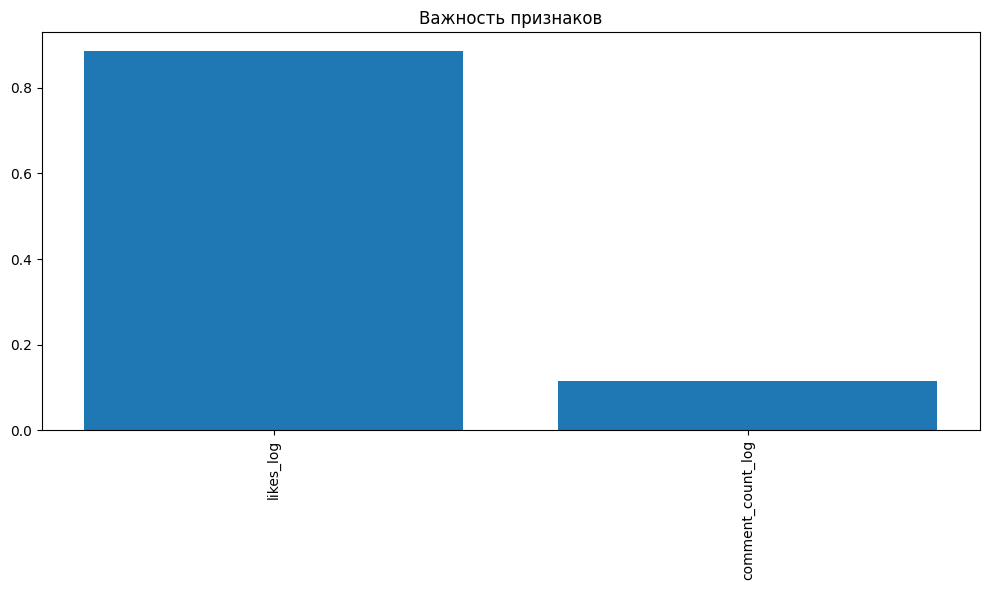

In [10]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(10,6))
plt.title("Важность признаков")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), names, rotation=90)
plt.tight_layout()
plt.show()


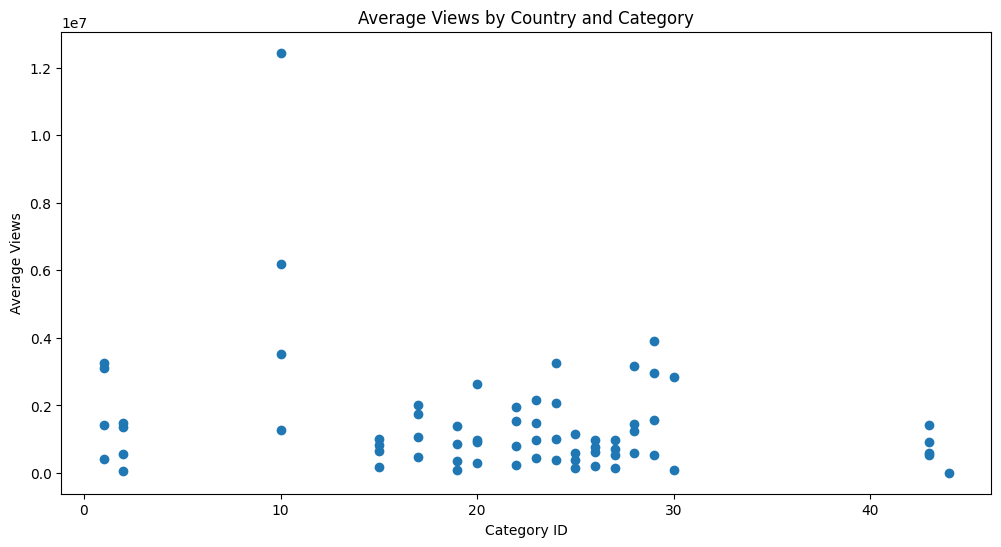

In [7]:
# Popularity by Country and Category
popularity = df.groupby(['publish_country', 'category_id'])['views'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.scatter(popularity['category_id'], popularity['views'])
plt.title('Average Views by Country and Category')
plt.xlabel('Category ID')
plt.ylabel('Average Views')
plt.show()

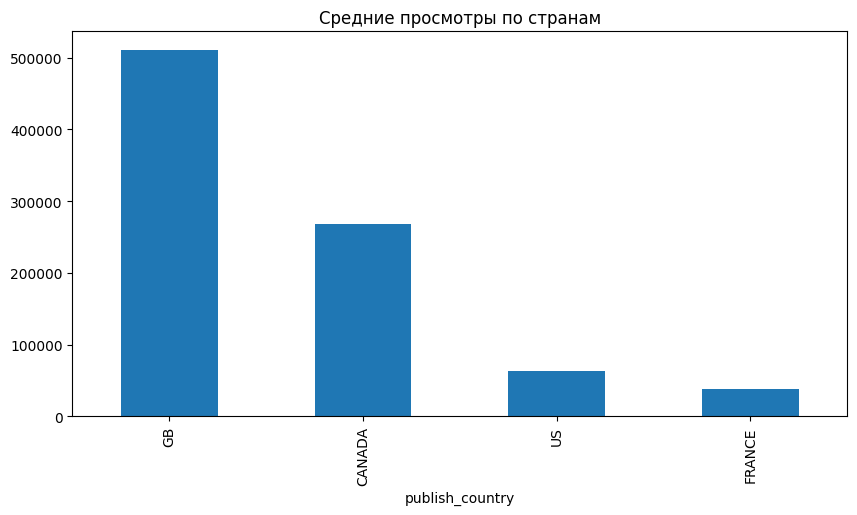

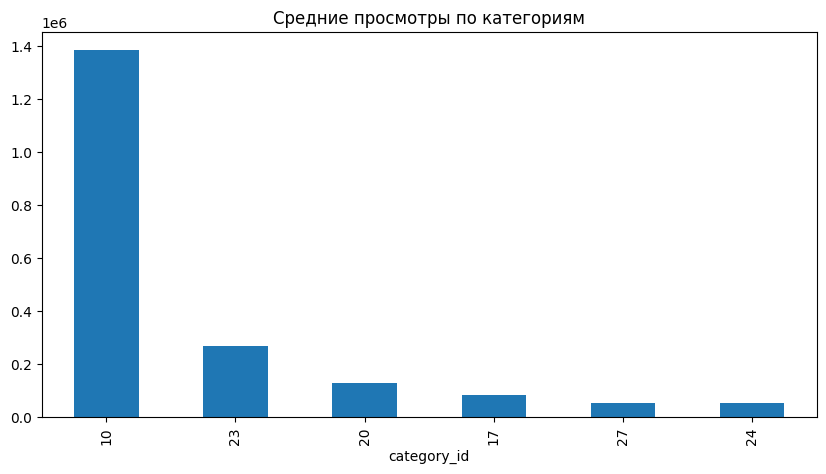

In [13]:
country_popularity = df.groupby('publish_country')['views'].mean().sort_values(ascending=False)
country_popularity.plot(kind='bar', figsize=(10,5), title='Средние просмотры по странам')
plt.show()

category_popularity = df.groupby('category_id')['views'].mean().sort_values(ascending=False)
category_popularity.plot(kind='bar', figsize=(10,5), title='Средние просмотры по категориям')
plt.show()


In [12]:
import joblib

joblib.dump(xgb, "youtube_views_model.pkl")
print("Модель сохранена как youtube_views_model.pkl")


Модель сохранена как youtube_views_model.pkl
